In [15]:
#%% env: new-ml

from array import array
from cmath import nan
from pyexpat import model
import statistics
from tkinter.ttk import Separator
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torchviz import make_dot
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
from torch.autograd import variable
from itertools import chain
from sklearn import metrics as met
import pickle
from icecream import ic

import matplotlib.pyplot as plt
import pathlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from importlib import reload
# import util
# import model_torch_simple
# from torchmetrics import Accuracy
from tqdm import tqdm   
import argparse
from icecream import ic
import numpy as np
from PIL import Image
device = 'cuda' if torch.cuda.is_available() else 'cpu'

import numpy as np
import pandas as pd
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#%%
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt


seed = 42
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

# train_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/aa_data_train_gene.csv', delimiter = ',')
# train_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/mic_aa_train_hml.csv')
# train_target = train_target[['EMB_MIC']]
# # don't touch test data, split out validation data from training data during training
# # test_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_EMB/aa_data_test_pca4k.csv', delimiter = ',')
# test_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/aa_data_test_gene.csv', delimiter = ',')
# test_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/mic_aa_test_hml.csv')
# test_target = test_target[['EMB_MIC']]

# all_data = np.concatenate((train_data, test_data), axis=0)
# all_target = pd.concat((train_target, test_target), axis=0)

# train_data, test_data, train_target, test_target = train_test_split(all_data, all_target, test_size=0.2, random_state=42, stratify=all_target)

In [16]:

def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')
    
def value_counts_list(lst):
    """
    Computes the frequency count of unique elements in a list and returns a dictionary, sorted by frequency count in
    descending order.

    Args:
    - lst (list): List of elements

    Returns:
    - dict: Dictionary with unique elements as keys and their frequency count as values, sorted by frequency count
      in descending order
    """
    value_counts = {}
    for item in lst:
        if item in value_counts:
            value_counts[item] += 1
        else:
            value_counts[item] = 1
    sorted_value_counts = dict(sorted(value_counts.items(), key=lambda x: x[1], reverse=True))
    return sorted_value_counts 

In [17]:
clinical_lung = pd.read_csv('/mnt/storageG1/lwang/Projects/TBpt/Analysis/clinical_lung_na11182024.csv')
clinical_lung.drop(columns=['condition_id'], inplace=True)

country_mapping = {
    'China': 1,        # High medical capacity, large infrastructure, advanced technology
    'India': 2,        # Large infrastructure, but strained capacity due to population
    'South Africa': 3, # Developed healthcare, but regional disparities
    'Romania': 4,      # Developing EU healthcare standards
    'Ukraine': 5,      # Moderate capacity but strained due to recent conflicts
    'Belarus': 6,      # Moderate capacity, state-funded healthcare
    'Kazakhstan': 7,   # Developing healthcare system
    'Azerbaijan': 8,   # Developing healthcare system
    'Georgia': 9,      # Smaller healthcare capacity, improving
    'Moldova': 10,     # Limited resources, developing healthcare
    'Kyrgyzstan': 11,  # Limited resources, developing healthcare
    'Nigeria': 12,     # Limited healthcare capacity, large population challenges
    'Senegal': 13      # Developing healthcare system with limited resources
}

# Apply the mapping to the 'country' column
clinical_lung['country'] = clinical_lung['country'].replace(country_mapping).fillna(0)
clinical_lung_cleaned = clinical_lung.drop_duplicates()
clinical_lung_features = clinical_lung.drop(columns=['outcome', 'period_span.1'])
clinical_lung_target = clinical_lung[['outcome']]

In [18]:
clinical_lung_target.value_counts()

outcome
1          7890
0          1991
Name: count, dtype: int64

## training/testing functions

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_xgboost_classifier(features, target, test_size=0.2, random_state=42):
    """
    Trains and evaluates an XGBoost classifier on the provided dataset.

    Parameters:
    - features (pd.DataFrame): The feature set.
    - target (pd.Series): The target variable.
    - test_size (float): Proportion of the dataset to include in the test split.
    - random_state (int): Random seed for reproducibility.

    Returns:
    - model (XGBClassifier): The trained XGBoost model.
    - metrics (dict): A dictionary containing accuracy, sensitivity, and specificity.
    """

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=test_size, random_state=random_state, stratify=target, shuffle=True
    )

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform both training and testing data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert the scaled arrays back to DataFrames to retain feature names
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features.columns)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=features.columns)

    # Initialize and train the XGBoost classifier
    model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=random_state)
    model.fit(X_train_scaled_df, y_train)

    # Predict on training and testing data
    y_train_pred = model.predict(X_train_scaled_df)
    y_test_pred = model.predict(X_test_scaled_df)

    # Calculate accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Calculate sensitivity (recall) and specificity
    sensitivity = recall_score(y_test, y_test_pred, pos_label=1)
    specificity = recall_score(y_test, y_test_pred, pos_label=0)

    # Compile metrics into a dictionary
    metrics = {
        # 'Training Accuracy': train_accuracy,
        'Testing Accuracy': test_accuracy,
        'Sensitivity (Recall)': sensitivity,
        'Specificity': specificity
    }

    # Print metrics
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value:.4f}")

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # Plot feature importance
    plt.figure(figsize=(15, 25))
    plot_importance(model, max_num_features=20, importance_type='weight', xlabel='Feature Importance')
    plt.title('Top 20 Feature Importances')
    plt.show()

    return model, metrics

# Example usage:
# Assuming 'clinical_lung_features' is your DataFrame of features
# and 'clinical_lung_target' is your target variable
# model, metrics = evaluate_xgboost_classifier(clinical_lung_features, clinical_lung_target)
import pandas as pd
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_xgboost_classifier_split(X_train, X_test, y_train, y_test, reg_alpha=0.1, reg_lambda=0.1, random_state=42):
    """
    Trains and evaluates an XGBoost classifier on the provided training and testing datasets.

    Parameters:
    - X_train (pd.DataFrame): Training feature set.
    - X_test (pd.DataFrame): Testing feature set.
    - y_train (pd.Series or np.array): Training target variable.
    - y_test (pd.Series or np.array): Testing target variable.
    - random_state (int): Random seed for reproducibility.

    Returns:
    - model (XGBClassifier): The trained XGBoost model.
    - metrics (dict): A dictionary containing accuracy, sensitivity, and specificity.
    """

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform both training and testing data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert the scaled arrays back to DataFrames to retain feature names
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    # Initialize and train the XGBoost classifier
    model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=random_state, reg_alpha=reg_alpha, reg_lambda=reg_lambda)
    model.fit(X_train_scaled_df, y_train)

    # Predict on training and testing data
    y_train_pred = model.predict(X_train_scaled_df)
    y_test_pred = model.predict(X_test_scaled_df)

    # Calculate accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Calculate sensitivity (recall) and specificity
    sensitivity = recall_score(y_test, y_test_pred, pos_label=1)
    specificity = recall_score(y_test, y_test_pred, pos_label=0)

    # Compile metrics into a dictionary
    metrics = {
        # 'Training Accuracy': train_accuracy,
        'Testing Accuracy': test_accuracy,
        'Sensitivity (Recall)': sensitivity,
        'Specificity': specificity
    }

    # Print metrics
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value:.4f}")

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # Plot feature importance
    plt.figure(figsize=(15, 25))
    plot_importance(model, max_num_features=20, importance_type='weight', xlabel='Feature Importance')
    plt.title('Top 20 Feature Importances')
    plt.show()

    return model, metrics

from sklearn.utils.class_weight import compute_class_weight

def evaluate_xgboost_classifier_split_weighted(X_train, X_test, y_train, y_test, reg_alpha=0.1, reg_lambda=0.1, random_state=42):
    """
    Trains and evaluates an XGBoost classifier on the provided training and testing datasets with weighted loss.

    Parameters:
    - X_train (pd.DataFrame): Training feature set.
    - X_test (pd.DataFrame): Testing feature set.
    - y_train (pd.Series or np.array): Training target variable.
    - y_test (pd.Series or np.array): Testing target variable.
    - random_state (int): Random seed for reproducibility.

    Returns:
    - model (XGBClassifier): The trained XGBoost model.
    - metrics (dict): A dictionary containing accuracy, sensitivity, and specificity.
    """

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform both training and testing data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert the scaled arrays back to DataFrames to retain feature names
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    # Calculate class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=np.array(y_train['outcome']))
    weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Calculate scale_pos_weight for binary classification
    if len(np.unique(y_train)) == 2:
        pos_class_weight = class_weights[1] / class_weights[0]
    else:
        pos_class_weight = None  # Adjust for multiclass if needed

    # Initialize and train the XGBoost classifier
    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=random_state,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        scale_pos_weight=pos_class_weight
    )
    model.fit(X_train_scaled_df, y_train)

    # Predict on training and testing data
    y_train_pred = model.predict(X_train_scaled_df)
    y_test_pred = model.predict(X_test_scaled_df)

    # Calculate accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Calculate sensitivity (recall) and specificity
    sensitivity = recall_score(y_test, y_test_pred, pos_label=1)
    specificity = recall_score(y_test, y_test_pred, pos_label=0)

    # Compile metrics into a dictionary
    metrics = {
        # 'Training Accuracy': train_accuracy,
        'Testing Accuracy': test_accuracy,
        'Sensitivity (Recall)': sensitivity,
        'Specificity': specificity
    }

    # Print metrics
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value:.4f}")

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # Plot feature importance
    plt.figure(figsize=(15, 25))
    plot_importance(model, max_num_features=20, importance_type='weight', xlabel='Feature Importance')
    plt.title('Top 20 Feature Importances')
    plt.show()

    return model, metrics

from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight

def evaluate_catboost_classifier_split_weighted(X_train, X_test, y_train, y_test, 
                                                 l2_leaf_reg=3.0, learning_rate=0.1, 
                                                 iterations=1000, depth=6, random_state=42):
    """
    Trains and evaluates a CatBoost classifier on the provided training and testing datasets with weighted loss.

    Parameters:
    - X_train (pd.DataFrame): Training feature set.
    - X_test (pd.DataFrame): Testing feature set.
    - y_train (pd.Series or np.array): Training target variable.
    - y_test (pd.Series or np.array): Testing target variable.
    - l2_leaf_reg (float): L2 regularization coefficient (default 3.0).
    - learning_rate (float): Learning rate for the CatBoost model (default 0.1).
    - iterations (int): Number of boosting iterations (default 1000).
    - depth (int): Depth of the trees (default 6).
    - random_state (int): Random seed for reproducibility.

    Returns:
    - model (CatBoostClassifier): The trained CatBoost model.
    - metrics (dict): A dictionary containing accuracy, sensitivity, and specificity.
    """

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform both training and testing data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert the scaled arrays back to DataFrames to retain feature names
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    # Calculate class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Prepare Pool objects for CatBoost
    train_pool = Pool(X_train_scaled_df, y_train, weight=[weight_dict[int(label)] for label in y_train])
    test_pool = Pool(X_test_scaled_df, y_test)

    # Initialize and train the CatBoost classifier
    model = CatBoostClassifier(
        iterations=iterations,
        learning_rate=learning_rate,
        depth=depth,
        l2_leaf_reg=l2_leaf_reg,
        loss_function='Logloss',
        random_seed=random_state,
        verbose=100,
        class_weights=list(class_weights)
    )
    model.fit(train_pool)

    # Predict on training and testing data
    y_train_pred = model.predict(X_train_scaled_df)
    y_test_pred = model.predict(X_test_scaled_df)

    # Calculate accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Calculate sensitivity (recall) and specificity
    sensitivity = recall_score(y_test, y_test_pred, pos_label=1)
    specificity = recall_score(y_test, y_test_pred, pos_label=0)

    # Compile metrics into a dictionary
    metrics = {
        'Testing Accuracy': test_accuracy,
        'Sensitivity (Recall)': sensitivity,
        'Specificity': specificity
    }

    # Print metrics
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value:.4f}")

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # Plot feature importance
    feature_importances = model.get_feature_importance()
    sorted_indices = np.argsort(feature_importances)[::-1]
    top_features = X_train.columns[sorted_indices][:20]
    top_importances = feature_importances[sorted_indices][:20]

    plt.figure(figsize=(10, 8))
    plt.barh(top_features, top_importances, color='skyblue')
    plt.gca().invert_yaxis()
    plt.title('Top 20 Feature Importances')
    plt.xlabel('Importance')
    plt.show()

    return model, metrics


Training Accuracy: 0.9951
Testing Accuracy: 0.9363
Sensitivity (Recall): 0.9768
Specificity: 0.7688


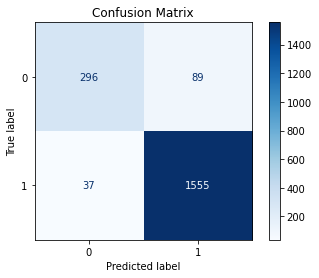

<Figure size 1080x1800 with 0 Axes>

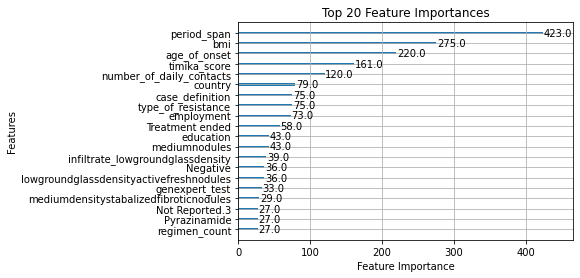

In [49]:
model, metrics = evaluate_xgboost_classifier(clinical_lung_features, clinical_lung_target)


## inputation with knn

Training Accuracy: 0.9968
Testing Accuracy: 0.9353
Sensitivity (Recall): 0.9793
Specificity: 0.7532


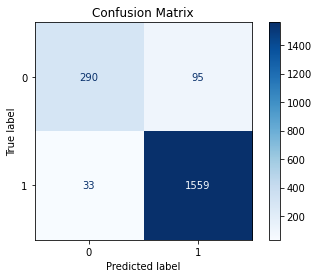

<Figure size 1080x1800 with 0 Axes>

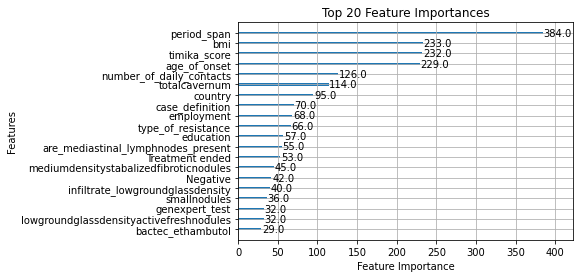

In [50]:
import pandas as pd
from sklearn.impute import KNNImputer

# Assuming 'clinical_lung_features' is your DataFrame with missing values

# Initialize the KNNImputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# Fit the imputer on the data and transform it
clinical_lung_features_imputed = imputer.fit_transform(clinical_lung_features)

# Convert the result back to a DataFrame
clinical_lung_features_imputed_df = pd.DataFrame(clinical_lung_features_imputed, columns=clinical_lung_features.columns)

# Optionally, replace the original DataFrame with the imputed one
clinical_lung_features = clinical_lung_features_imputed_df

model, metrics = evaluate_xgboost_classifier(clinical_lung_features, clinical_lung_target)


## dropping period span columns

In [ ]:
clinical_lung_features['period_span']

Training Accuracy: 0.9877
Testing Accuracy: 0.8912
Sensitivity (Recall): 0.9604
Specificity: 0.6052


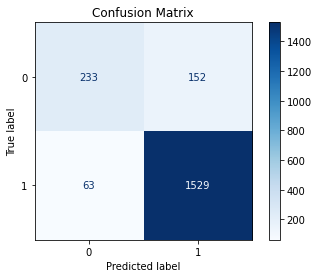

<Figure size 1080x1800 with 0 Axes>

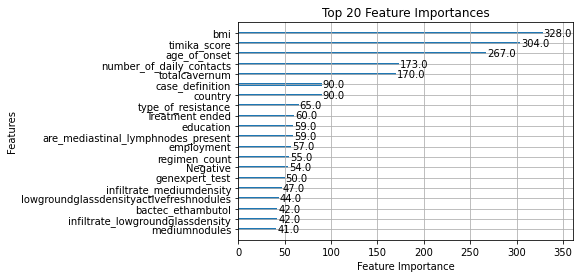

In [59]:
import pandas as pd
from sklearn.impute import KNNImputer

# Assuming 'clinical_lung_features' is your DataFrame with missing values

# Initialize the KNNImputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# Fit the imputer on the data and transform it
clinical_lung_features_imputed = imputer.fit_transform(clinical_lung_features)

# Convert the result back to a DataFrame
clinical_lung_features_imputed_df = pd.DataFrame(clinical_lung_features_imputed, columns=clinical_lung_features.columns)

clinical_lung_features_imputed_df = clinical_lung_features_imputed_df.drop(columns=['period_span.1'])
# Optionally, replace the original DataFrame with the imputed one
clinical_lung_features = clinical_lung_features_imputed_df

model, metrics = evaluate_xgboost_classifier(clinical_lung_features, clinical_lung_target)


removing period span drops specificity from 73 to 60, acc drop from 98 to 89

## adding pca 
hoping to reduce imbalance and improve specificity

Testing Accuracy: 0.8766
Sensitivity (Recall): 0.9655
Specificity: 0.5091


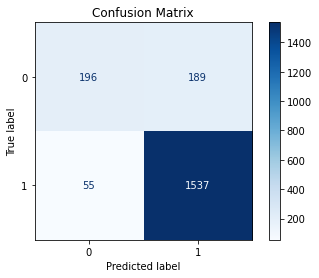

<Figure size 1080x1800 with 0 Axes>

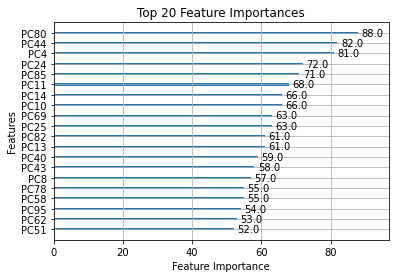

In [64]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming 'clinical_lung_features' is your DataFrame with missing values

# Step 1: Impute Missing Values Using KNNImputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
clinical_lung_features_imputed = imputer.fit_transform(clinical_lung_features)
clinical_lung_features_imputed_df = pd.DataFrame(clinical_lung_features_imputed, columns=clinical_lung_features.columns)

# Step 2: Remove the 'period_span.1' Variable
# clinical_lung_features_imputed_df = clinical_lung_features_imputed_df.drop(columns=['period_span.1'])

# Step 3: Standardize the Features
scaler = StandardScaler()
clinical_lung_features_scaled = scaler.fit_transform(clinical_lung_features_imputed_df)

# Step 4: Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
clinical_lung_features_pca = pca.fit_transform(clinical_lung_features_scaled)

# Convert the PCA result back to a DataFrame
pca_columns = [f'PC{i+1}' for i in range(clinical_lung_features_pca.shape[1])]
clinical_lung_features_pca_df = pd.DataFrame(clinical_lung_features_pca, columns=pca_columns)

# Optional: Replace the original DataFrame with the PCA-transformed one
clinical_lung_features = clinical_lung_features_pca_df

# Proceed with model evaluation
model, metrics = evaluate_xgboost_classifier(clinical_lung_features, clinical_lung_target)


apparently pca doesn't have the same feature importance as the xgb model

## balancing the data

In [85]:
clinical_lung_target.value_counts()

outcome
1          7890
0          1991
Name: count, dtype: int64

Testing Accuracy: 0.9155
Sensitivity (Recall): 0.9291
Specificity: 0.8618


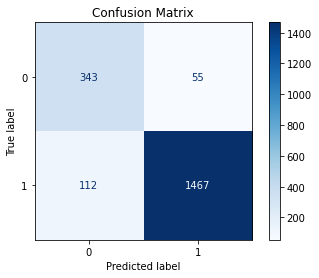

<Figure size 1080x1800 with 0 Axes>

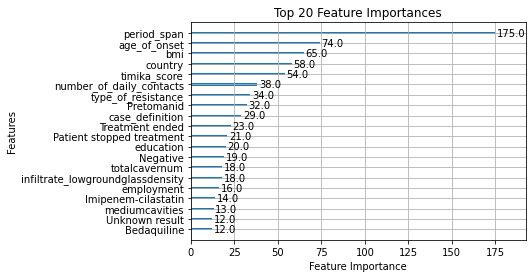

(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='mlogloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=None, num_parallel_tree=None, random_state=42, ...),
 {'Testing Accuracy': 0.9155285786545271,
  'Sensitivity (Recall)': 0.9290690310322989,
  'Specificity': 0.8618090452261307})

In [ ]:
import pandas as pd
from sklearn.utils import resample

# Assuming 'clinical_lung' is your DataFrame and 'outcome' is the target column
X_train, X_test, y_train, y_test = train_test_split(
    clinical_lung_features, clinical_lung_target, test_size=0.2, random_state=42, stratify=clinical_lung_target, shuffle=True
)

from imblearn.over_sampling import RandomOverSampler

# Initialize the RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Fit and resample the training data
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# evaluate_xgboost_classifier_split(X_train_resampled, X_test, y_train_resampled, y_test, reg_alpha=0.3, reg_lambda=19,  random_state=42)
evaluate_xgboost_classifier_split(X_train_resampled, X_test, y_train_resampled, y_test, reg_alpha=29, reg_lambda=29,  random_state=42)
# evaluate_xgboost_classifier_split(X_train_resampled, X_test, y_train_resampled, y_test, reg_alpha=219, reg_lambda=919,  random_state=42)

Testing Accuracy: 0.9155
Sensitivity (Recall): 0.9291
Specificity: 0.8618


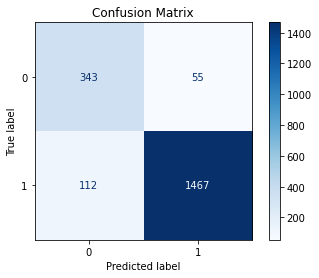

<Figure size 1080x1800 with 0 Axes>

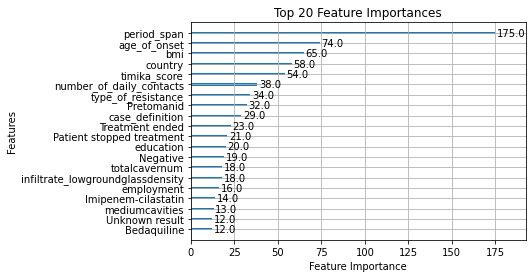

(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='mlogloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=None, num_parallel_tree=None, random_state=42, ...),
 {'Testing Accuracy': 0.9155285786545271,
  'Sensitivity (Recall)': 0.9290690310322989,
  'Specificity': 0.8618090452261307})

In [170]:
import pandas as pd
from sklearn.utils import resample

# Assuming 'clinical_lung' is your DataFrame and 'outcome' is the target column
X_train, X_test, y_train, y_test = train_test_split(
    clinical_lung_features, clinical_lung_target, test_size=0.2, random_state=42, stratify=clinical_lung_target, shuffle=True
)

from imblearn.over_sampling import RandomOverSampler

# Initialize the RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Fit and resample the training data
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# evaluate_xgboost_classifier_split(X_train_resampled, X_test, y_train_resampled, y_test, reg_alpha=0.3, reg_lambda=19,  random_state=42)
evaluate_xgboost_classifier_split(X_train_resampled, X_test, y_train_resampled, y_test, reg_alpha=29, reg_lambda=29,  random_state=42)
# evaluate_xgboost_classifier_split(X_train_resampled, X_test, y_train_resampled, y_test, reg_alpha=219, reg_lambda=919,  random_state=42)

#### different imputation methods

In [166]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

imputation_methods = {
    'Mean Imputation': SimpleImputer(strategy='mean'),
    'Median Imputation': SimpleImputer(strategy='median'),
    'Most Frequent Imputation': SimpleImputer(strategy='most_frequent'),
    'Constant Imputation': SimpleImputer(strategy='constant', fill_value=0),
    'KNN Imputation': KNNImputer(n_neighbors=5),
    'Iterative Imputation': IterativeImputer(random_state=42)
}


### testing imputation methods

Evaluating Mean Imputation...
Accuracy: 0.9287
Sensitivity (Recall): 0.9607
Specificity: 0.8015


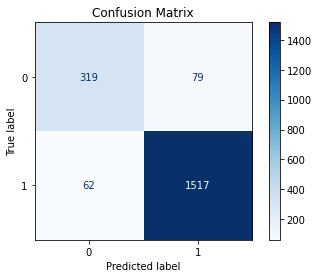

Evaluating Median Imputation...
Accuracy: 0.9347
Sensitivity (Recall): 0.9664
Specificity: 0.8090


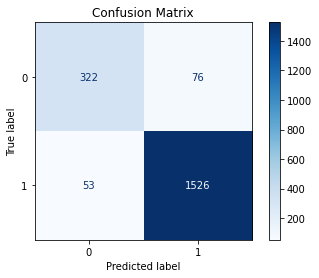

Evaluating Most Frequent Imputation...
Accuracy: 0.9312
Sensitivity (Recall): 0.9601
Specificity: 0.8166


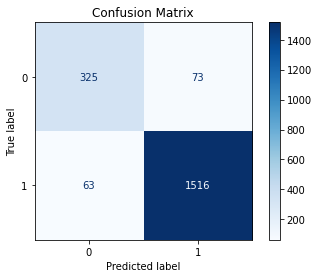

Evaluating Constant Imputation...
Accuracy: 0.9322
Sensitivity (Recall): 0.9639
Specificity: 0.8065


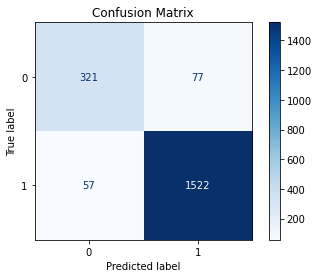

Evaluating KNN Imputation...
Accuracy: 0.9312
Sensitivity (Recall): 0.9607
Specificity: 0.8141


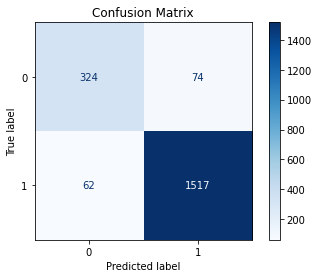

Evaluating Iterative Imputation...
Accuracy: 0.9262
Sensitivity (Recall): 0.9607
Specificity: 0.7889


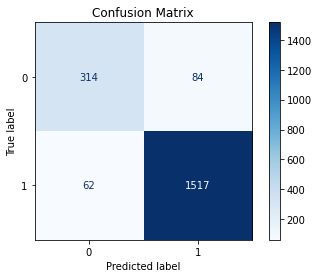

In [169]:
def evaluate_imputation_method(imputer, X, y, test_size=0.2, random_state=42):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y, shuffle=True
    )
    # Apply imputation to training and testing data separately
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform both training and testing data
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)

    # Resample the training data to address class imbalance
    ros = RandomOverSampler(random_state=random_state)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train_scaled, y_train)

    # Initialize and train the XGBoost classifier
    model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=random_state)
    model.fit(X_train_resampled, y_train_resampled)

    # Predict on the test data
    y_test_pred = model.predict(X_test_scaled)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_test_pred)

    # Calculate sensitivity (recall) and specificity
    sensitivity = recall_score(y_test, y_test_pred, pos_label=1)
    specificity = recall_score(y_test, y_test_pred, pos_label=0)

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)

    # Compile metrics into a dictionary
    metrics = {
        'Accuracy': accuracy,
        'Sensitivity (Recall)': sensitivity,
        'Specificity': specificity
    }

    # Print metrics
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value:.4f}")

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    return metrics, model, cm
# Assuming 'clinical_lung_features' is your DataFrame of features
# and 'clinical_lung_target' is your target variable

results = {}

for method_name, imputer in imputation_methods.items():
    print(f"Evaluating {method_name}...")
    metrics, model, cm  = evaluate_imputation_method(imputer, clinical_lung_features, clinical_lung_target)
    # results[method_name] = accuracy
    # print(f"{method_name} Accuracy: {accuracy:.4f}\n")
    # print(metrics)
    # print(cm)



### imputating with the most frequent value

Testing Accuracy: 0.9110
Sensitivity (Recall): 0.9234
Specificity: 0.8618


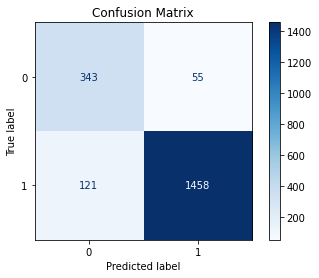

<Figure size 1080x1800 with 0 Axes>

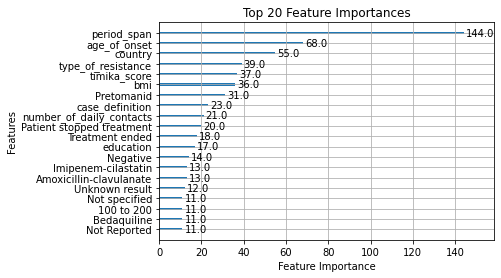

(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='mlogloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=None, num_parallel_tree=None, random_state=42, ...),
 {'Testing Accuracy': 0.9109762266059687,
  'Sensitivity (Recall)': 0.9233692210259657,
  'Specificity': 0.8618090452261307})

In [185]:
imputer = SimpleImputer(strategy='most_frequent')

# Fit the imputer on the data and transform it
clinical_lung_features_imputed = imputer.fit_transform(clinical_lung_features)

# Convert the result back to a DataFrame
clinical_lung_features_imputed_df = pd.DataFrame(clinical_lung_features_imputed, columns=clinical_lung_features.columns)

# Optionally, replace the original DataFrame with the imputed one
clinical_lung_features = clinical_lung_features_imputed_df

import pandas as pd
from sklearn.utils import resample

# Assuming 'clinical_lung' is your DataFrame and 'outcome' is the target column
X_train, X_test, y_train, y_test = train_test_split(
    clinical_lung_features, clinical_lung_target, test_size=0.2, random_state=42, stratify=clinical_lung_target, shuffle=True
)

from imblearn.over_sampling import RandomOverSampler

# Initialize the RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Fit and resample the training data
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# evaluate_xgboost_classifier_split(X_train_resampled, X_test, y_train_resampled, y_test, reg_alpha=0.3, reg_lambda=19,  random_state=42)
evaluate_xgboost_classifier_split(X_train_resampled, X_test, y_train_resampled, y_test, reg_alpha=38, reg_lambda=69,  random_state=42)

### **Incorporate Class Weights

In [222]:
clinical_lung_target.value_counts()   



outcome
1          7890
0          1991
Name: count, dtype: int64

Testing Accuracy: 0.9110
Sensitivity (Recall): 0.9234
Specificity: 0.8618


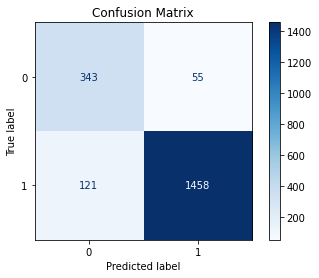

<Figure size 1080x1800 with 0 Axes>

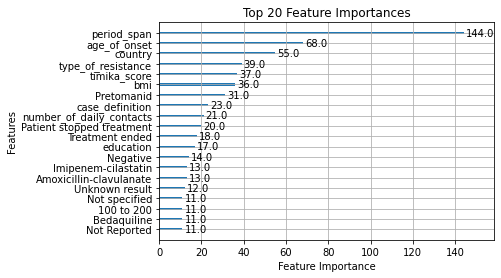

(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='mlogloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=None, num_parallel_tree=None, random_state=42, ...),
 {'Testing Accuracy': 0.9109762266059687,
  'Sensitivity (Recall)': 0.9233692210259657,
  'Specificity': 0.8618090452261307})

In [ ]:
imputer = SimpleImputer(strategy='most_frequent')

# Fit the imputer on the data and transform it
clinical_lung_features_imputed = imputer.fit_transform(clinical_lung_features)

# Convert the result back to a DataFrame
clinical_lung_features_imputed_df = pd.DataFrame(clinical_lung_features_imputed, columns=clinical_lung_features.columns)

# Optionally, replace the original DataFrame with the imputed one
clinical_lung_features = clinical_lung_features_imputed_df

import pandas as pd
from sklearn.utils import resample

# Assuming 'clinical_lung' is your DataFrame and 'outcome' is the target column
X_train, X_test, y_train, y_test = train_test_split(
    clinical_lung_features, clinical_lung_target, test_size=0.2, random_state=42, stratify=clinical_lung_target, shuffle=True
)

from imblearn.over_sampling import RandomOverSampler

# target_counts = {
#     1.0: 6311,  # Keep the majority class as is
#     0.0: 3311,  # Bring other classes closer
# }
# Initialize the RandomOverSampler
# ros = RandomOverSampler(random_state=42, sampling_strategy=target_counts)
ros = RandomOverSampler(random_state=42)

# Fit and resample the training data
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# evaluate_xgboost_classifier_split(X_train_resampled, X_test, y_train_resampled, y_test, reg_alpha=0.3, reg_lambda=19,  random_state=42)
# evaluate_xgboost_classifier_split_weighted(X_train_resampled, X_test, y_train_resampled, y_test, reg_alpha=38, reg_lambda=69,  random_state=42)
# evaluate_xgboost_classifier_split(X_train_resampled, X_test, y_train_resampled, y_test, reg_alpha=38, reg_lambda=69,  random_state=42)
evaluate_xgboost_classifier_split_weighted(X_train_resampled, X_test, y_train_resampled, y_test, reg_alpha=38, reg_lambda=69,  random_state=42)

no effect

#### catboost try

0:	learn: 0.6096311	total: 22.4ms	remaining: 33.6s
100:	learn: 0.1740013	total: 2.31s	remaining: 32s
200:	learn: 0.1360552	total: 4.38s	remaining: 28.3s
300:	learn: 0.1139377	total: 6.45s	remaining: 25.7s
400:	learn: 0.0954398	total: 8.53s	remaining: 23.4s
500:	learn: 0.0870746	total: 10.4s	remaining: 20.8s
600:	learn: 0.0762930	total: 12.4s	remaining: 18.6s
700:	learn: 0.0696346	total: 14.4s	remaining: 16.4s
800:	learn: 0.0614744	total: 16.5s	remaining: 14.4s
900:	learn: 0.0523480	total: 18.7s	remaining: 12.4s
1000:	learn: 0.0456143	total: 20.8s	remaining: 10.4s
1100:	learn: 0.0417155	total: 22.8s	remaining: 8.26s
1200:	learn: 0.0367241	total: 24.9s	remaining: 6.21s
1300:	learn: 0.0342204	total: 26.9s	remaining: 4.11s
1400:	learn: 0.0313254	total: 28.9s	remaining: 2.04s
1499:	learn: 0.0283331	total: 31s	remaining: 0us
Testing Accuracy: 0.9368
Sensitivity (Recall): 0.9677
Specificity: 0.8141


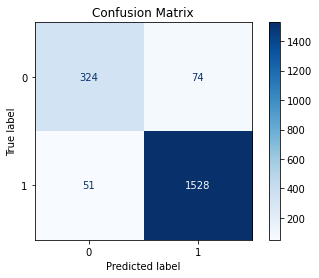

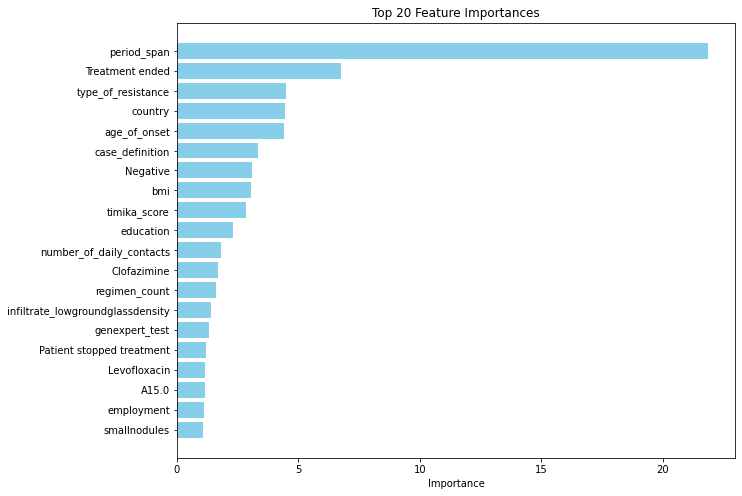

In [30]:

imputer = SimpleImputer(strategy='most_frequent')

# Fit the imputer on the data and transform it
clinical_lung_features_imputed = imputer.fit_transform(clinical_lung_features)

# Convert the result back to a DataFrame
clinical_lung_features_imputed_df = pd.DataFrame(clinical_lung_features_imputed, columns=clinical_lung_features.columns)

# Optionally, replace the original DataFrame with the imputed one
clinical_lung_features = clinical_lung_features_imputed_df

import pandas as pd
from sklearn.utils import resample

# Assuming 'clinical_lung' is your DataFrame and 'outcome' is the target column
X_train, X_test, y_train, y_test = train_test_split(
    clinical_lung_features, clinical_lung_target, test_size=0.2, random_state=42, stratify=clinical_lung_target, shuffle=True
)

from imblearn.over_sampling import RandomOverSampler

# target_counts = {
#     1.0: 6311,  # Keep the majority class as is
#     0.0: 3311,  # Bring other classes closer
# }
# Initialize the RandomOverSampler
# ros = RandomOverSampler(random_state=42, sampling_strategy=target_counts)
ros = RandomOverSampler(random_state=42)

# Fit and resample the training data
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)


model, metrics = evaluate_catboost_classifier_split_weighted(
    X_train_resampled, X_test, y_train_resampled['outcome'], y_test, 
    l2_leaf_reg=40.0, learning_rate=0.1, iterations=1500, depth=8, random_state=42
)


Testing parameters: {'l2_leaf_reg': 1.0, 'learning_rate': 0.01}
0:	learn: 0.6825276	total: 27.8ms	remaining: 41.6s
100:	learn: 0.3088750	total: 2.53s	remaining: 35.1s
200:	learn: 0.2441598	total: 4.96s	remaining: 32.1s
300:	learn: 0.2118508	total: 7.37s	remaining: 29.3s
400:	learn: 0.1885627	total: 9.67s	remaining: 26.5s
500:	learn: 0.1699963	total: 12s	remaining: 24s
600:	learn: 0.1550520	total: 14.3s	remaining: 21.5s
700:	learn: 0.1423752	total: 16.7s	remaining: 19s
800:	learn: 0.1313245	total: 19s	remaining: 16.6s
900:	learn: 0.1206746	total: 21.4s	remaining: 14.2s
1000:	learn: 0.1105793	total: 23.7s	remaining: 11.8s
1100:	learn: 0.1010273	total: 26s	remaining: 9.44s
1200:	learn: 0.0928194	total: 28.3s	remaining: 7.05s
1300:	learn: 0.0855933	total: 30.5s	remaining: 4.67s
1400:	learn: 0.0795244	total: 32.8s	remaining: 2.32s
1499:	learn: 0.0738902	total: 35.2s	remaining: 0us
Testing Accuracy: 0.9317
Sensitivity (Recall): 0.9607
Specificity: 0.8166


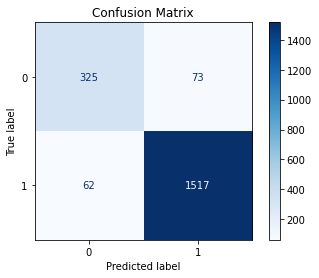

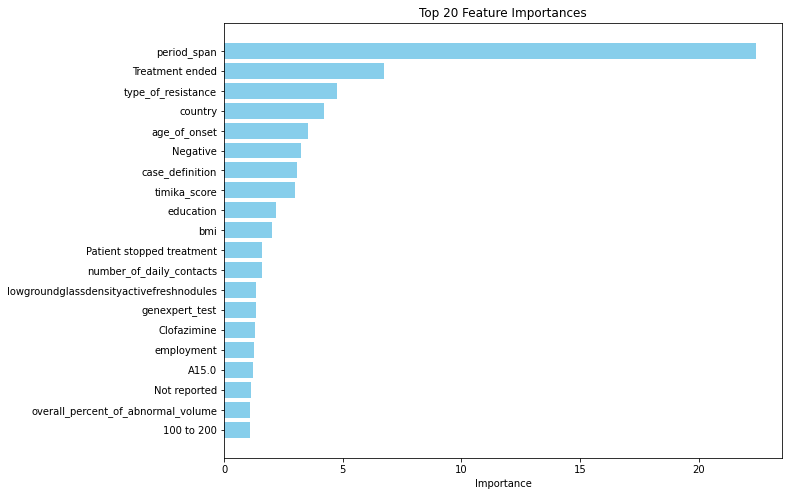

Testing parameters: {'l2_leaf_reg': 1.0, 'learning_rate': 0.05}
0:	learn: 0.6421700	total: 33.2ms	remaining: 49.7s
100:	learn: 0.1733168	total: 2.41s	remaining: 33.4s
200:	learn: 0.1113061	total: 4.7s	remaining: 30.3s
300:	learn: 0.0725296	total: 7s	remaining: 27.9s
400:	learn: 0.0491119	total: 9.26s	remaining: 25.4s
500:	learn: 0.0358331	total: 11.5s	remaining: 22.9s
600:	learn: 0.0265866	total: 13.9s	remaining: 20.8s
700:	learn: 0.0201743	total: 16.2s	remaining: 18.5s
800:	learn: 0.0156225	total: 18.5s	remaining: 16.2s
900:	learn: 0.0123935	total: 20.9s	remaining: 13.9s
1000:	learn: 0.0099990	total: 23.2s	remaining: 11.6s
1100:	learn: 0.0083504	total: 25.5s	remaining: 9.26s
1200:	learn: 0.0069249	total: 27.9s	remaining: 6.94s
1300:	learn: 0.0058743	total: 30.1s	remaining: 4.6s
1400:	learn: 0.0050809	total: 32.2s	remaining: 2.28s
1499:	learn: 0.0046500	total: 34.1s	remaining: 0us
Testing Accuracy: 0.9358
Sensitivity (Recall): 0.9728
Specificity: 0.7889


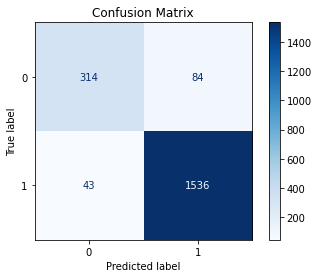

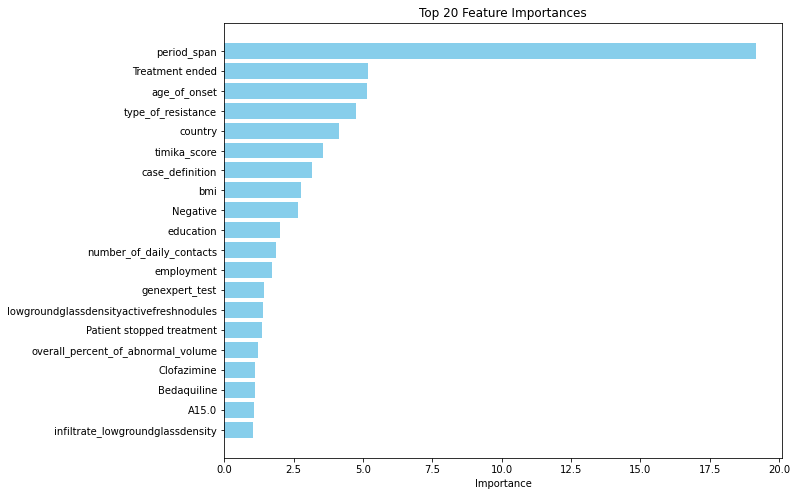

Testing parameters: {'l2_leaf_reg': 1.0, 'learning_rate': 0.1}
0:	learn: 0.5964524	total: 25.2ms	remaining: 37.8s
100:	learn: 0.1135684	total: 2.31s	remaining: 32.1s
200:	learn: 0.0502505	total: 4.59s	remaining: 29.7s
300:	learn: 0.0256615	total: 6.84s	remaining: 27.3s
400:	learn: 0.0150024	total: 9.07s	remaining: 24.9s
500:	learn: 0.0099623	total: 11.3s	remaining: 22.5s
600:	learn: 0.0066366	total: 13.5s	remaining: 20.2s
700:	learn: 0.0051800	total: 15.6s	remaining: 17.8s
800:	learn: 0.0046953	total: 17.4s	remaining: 15.2s
900:	learn: 0.0044233	total: 19.1s	remaining: 12.7s
1000:	learn: 0.0041602	total: 20.9s	remaining: 10.4s
1100:	learn: 0.0040389	total: 22.5s	remaining: 8.16s
1200:	learn: 0.0039930	total: 24.1s	remaining: 6.01s
1300:	learn: 0.0038968	total: 25.8s	remaining: 3.95s
1400:	learn: 0.0037793	total: 27.6s	remaining: 1.95s
1499:	learn: 0.0036784	total: 29.3s	remaining: 0us
Testing Accuracy: 0.9373
Sensitivity (Recall): 0.9721
Specificity: 0.7990


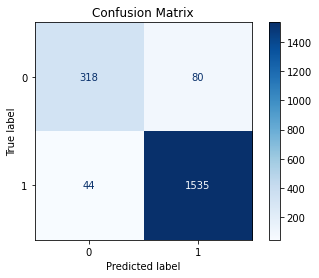

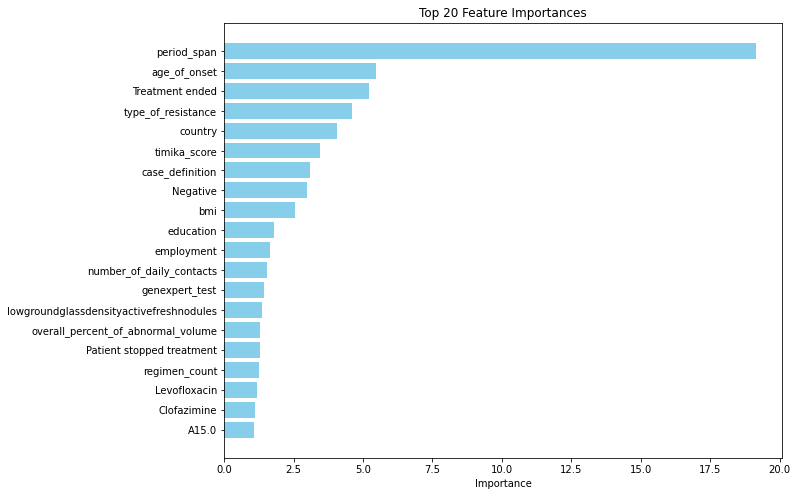

Testing parameters: {'l2_leaf_reg': 1.0, 'learning_rate': 0.2}
0:	learn: 0.5199418	total: 29.1ms	remaining: 43.6s
100:	learn: 0.0497190	total: 2.43s	remaining: 33.7s
200:	learn: 0.0141226	total: 4.78s	remaining: 30.9s
300:	learn: 0.0058770	total: 7.11s	remaining: 28.3s
400:	learn: 0.0038973	total: 9.12s	remaining: 25s
500:	learn: 0.0035823	total: 10.9s	remaining: 21.7s
600:	learn: 0.0032527	total: 12.6s	remaining: 18.9s
700:	learn: 0.0032071	total: 14.3s	remaining: 16.3s
800:	learn: 0.0030429	total: 16s	remaining: 14s
900:	learn: 0.0030407	total: 17.7s	remaining: 11.7s
1000:	learn: 0.0030181	total: 19.3s	remaining: 9.63s
1100:	learn: 0.0030010	total: 21s	remaining: 7.62s
1200:	learn: 0.0029589	total: 22.7s	remaining: 5.65s
1300:	learn: 0.0029565	total: 24.4s	remaining: 3.73s
1400:	learn: 0.0029544	total: 26.1s	remaining: 1.84s
1499:	learn: 0.0029522	total: 27.7s	remaining: 0us
Testing Accuracy: 0.9337
Sensitivity (Recall): 0.9715
Specificity: 0.7839


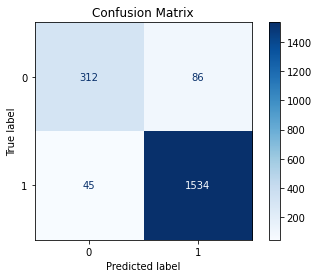

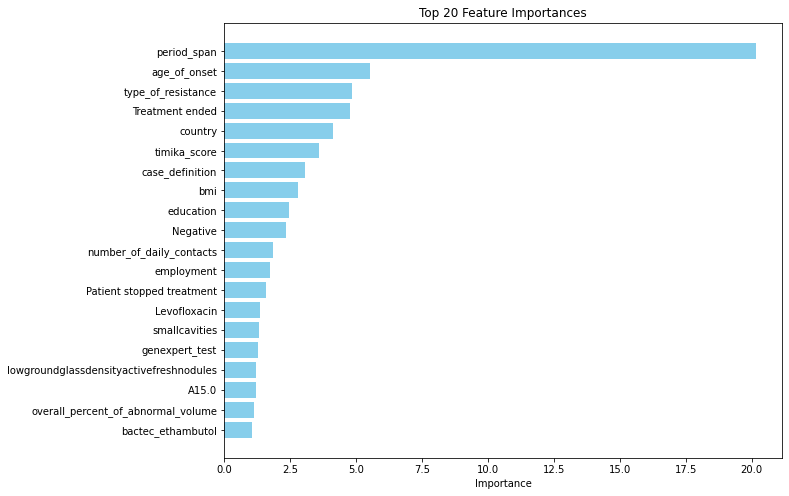

Testing parameters: {'l2_leaf_reg': 5.0, 'learning_rate': 0.01}
0:	learn: 0.6830426	total: 24ms	remaining: 35.9s
100:	learn: 0.3201336	total: 2.42s	remaining: 33.6s
200:	learn: 0.2569159	total: 4.81s	remaining: 31.1s
300:	learn: 0.2253955	total: 7.18s	remaining: 28.6s
400:	learn: 0.2038930	total: 9.53s	remaining: 26.1s
500:	learn: 0.1870938	total: 11.9s	remaining: 23.7s
600:	learn: 0.1730950	total: 14.2s	remaining: 21.3s
700:	learn: 0.1610511	total: 16.5s	remaining: 18.9s
800:	learn: 0.1505597	total: 18.9s	remaining: 16.5s
900:	learn: 0.1408946	total: 21.3s	remaining: 14.2s
1000:	learn: 0.1312528	total: 23.7s	remaining: 11.8s
1100:	learn: 0.1230172	total: 26.1s	remaining: 9.46s
1200:	learn: 0.1160948	total: 28.5s	remaining: 7.09s
1300:	learn: 0.1099417	total: 30.8s	remaining: 4.71s
1400:	learn: 0.1044990	total: 33.1s	remaining: 2.34s
1499:	learn: 0.0986310	total: 35.4s	remaining: 0us
Testing Accuracy: 0.9317
Sensitivity (Recall): 0.9557
Specificity: 0.8367


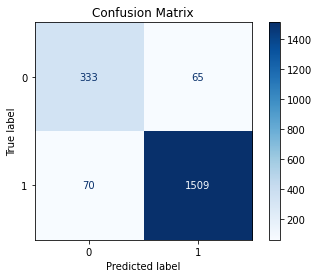

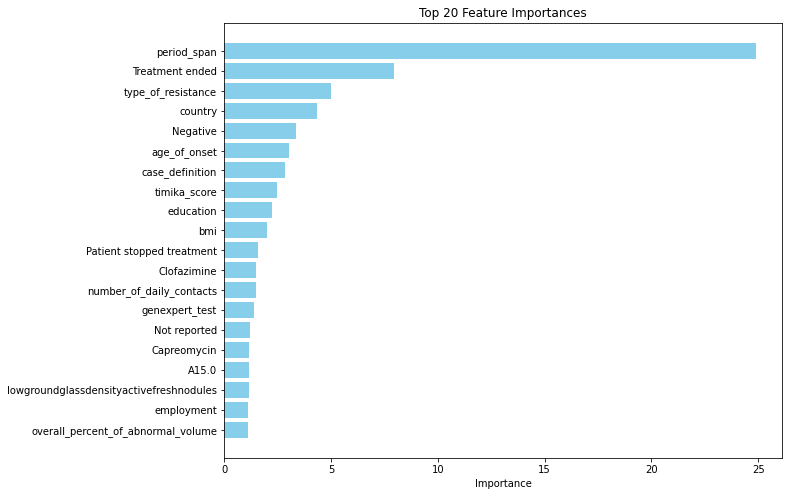

Testing parameters: {'l2_leaf_reg': 5.0, 'learning_rate': 0.05}
0:	learn: 0.6444830	total: 27.4ms	remaining: 41.1s
100:	learn: 0.1892012	total: 2.43s	remaining: 33.7s
200:	learn: 0.1362715	total: 4.75s	remaining: 30.7s
300:	learn: 0.1000136	total: 7.09s	remaining: 28.2s
400:	learn: 0.0770381	total: 9.38s	remaining: 25.7s
500:	learn: 0.0602156	total: 11.7s	remaining: 23.3s
600:	learn: 0.0474287	total: 14s	remaining: 21s
700:	learn: 0.0384847	total: 16.4s	remaining: 18.6s
800:	learn: 0.0319587	total: 18.7s	remaining: 16.3s
900:	learn: 0.0284173	total: 20.8s	remaining: 13.8s
1000:	learn: 0.0248516	total: 23s	remaining: 11.4s
1100:	learn: 0.0232232	total: 24.9s	remaining: 9.03s
1200:	learn: 0.0209792	total: 27.1s	remaining: 6.74s
1300:	learn: 0.0187141	total: 29.2s	remaining: 4.47s
1400:	learn: 0.0169511	total: 31.4s	remaining: 2.22s
1499:	learn: 0.0153812	total: 33.5s	remaining: 0us
Testing Accuracy: 0.9378
Sensitivity (Recall): 0.9709
Specificity: 0.8065


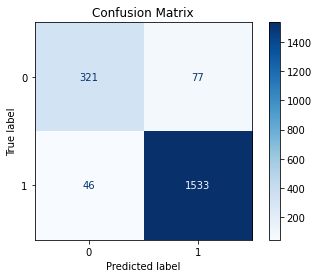

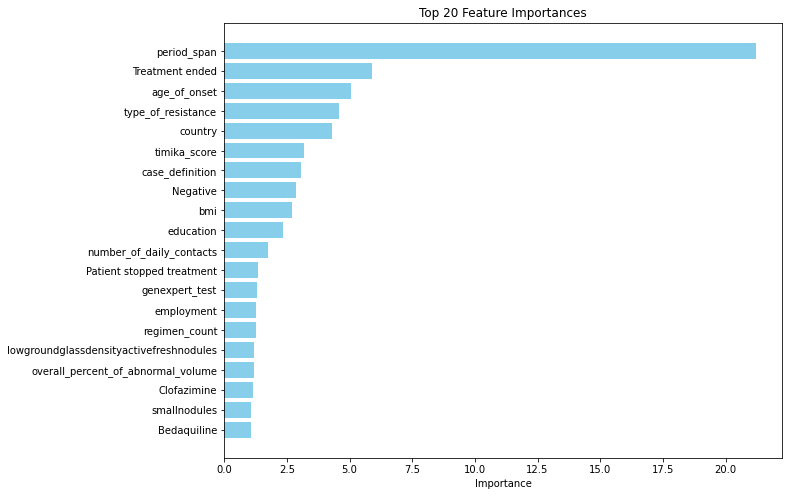

Testing parameters: {'l2_leaf_reg': 5.0, 'learning_rate': 0.1}
0:	learn: 0.6004504	total: 28.9ms	remaining: 43.4s
100:	learn: 0.1301958	total: 2.34s	remaining: 32.4s
200:	learn: 0.0766688	total: 4.53s	remaining: 29.3s
300:	learn: 0.0472148	total: 6.75s	remaining: 26.9s
400:	learn: 0.0322762	total: 8.95s	remaining: 24.5s
500:	learn: 0.0234697	total: 11.2s	remaining: 22.3s
600:	learn: 0.0178794	total: 13.5s	remaining: 20.2s
700:	learn: 0.0156798	total: 15.5s	remaining: 17.6s
800:	learn: 0.0132251	total: 17.6s	remaining: 15.3s
900:	learn: 0.0114845	total: 19.6s	remaining: 13.1s
1000:	learn: 0.0108882	total: 21.5s	remaining: 10.7s
1100:	learn: 0.0104316	total: 23.2s	remaining: 8.41s
1200:	learn: 0.0091377	total: 25.3s	remaining: 6.29s
1300:	learn: 0.0081101	total: 27.2s	remaining: 4.16s
1400:	learn: 0.0078159	total: 28.9s	remaining: 2.04s
1499:	learn: 0.0075601	total: 30.7s	remaining: 0us
Testing Accuracy: 0.9363
Sensitivity (Recall): 0.9715
Specificity: 0.7965


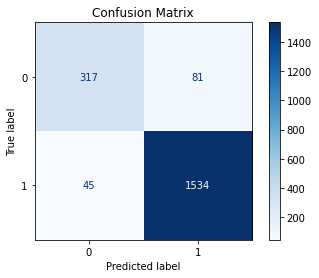

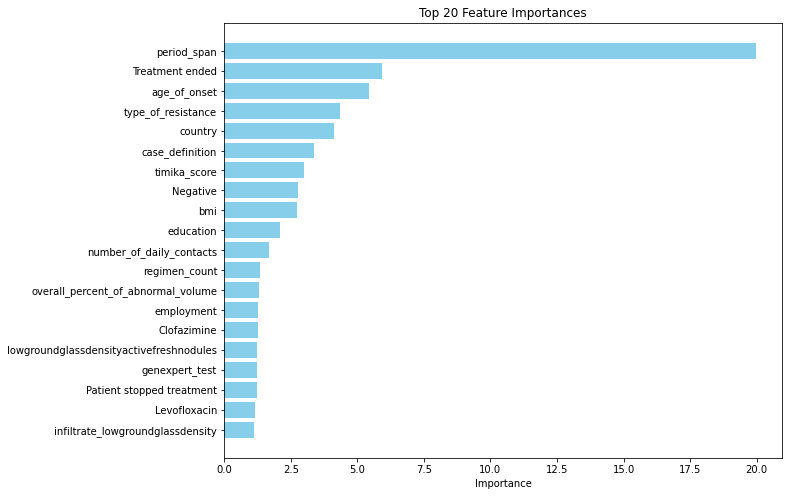

Testing parameters: {'l2_leaf_reg': 5.0, 'learning_rate': 0.2}
0:	learn: 0.5257297	total: 24.9ms	remaining: 37.4s
100:	learn: 0.0740396	total: 2.35s	remaining: 32.5s
200:	learn: 0.0308885	total: 4.64s	remaining: 30s
300:	learn: 0.0175235	total: 6.89s	remaining: 27.4s
400:	learn: 0.0117625	total: 9.1s	remaining: 24.9s
500:	learn: 0.0095881	total: 11.1s	remaining: 22s
600:	learn: 0.0089192	total: 12.8s	remaining: 19.2s
700:	learn: 0.0079596	total: 14.6s	remaining: 16.7s
800:	learn: 0.0069719	total: 16.5s	remaining: 14.4s
900:	learn: 0.0067138	total: 18.2s	remaining: 12.1s
1000:	learn: 0.0065277	total: 19.9s	remaining: 9.89s
1100:	learn: 0.0061848	total: 21.6s	remaining: 7.82s
1200:	learn: 0.0060817	total: 23.2s	remaining: 5.78s
1300:	learn: 0.0059751	total: 24.9s	remaining: 3.81s
1400:	learn: 0.0057459	total: 26.6s	remaining: 1.88s
1499:	learn: 0.0057289	total: 28.2s	remaining: 0us
Testing Accuracy: 0.9398
Sensitivity (Recall): 0.9721
Specificity: 0.8116


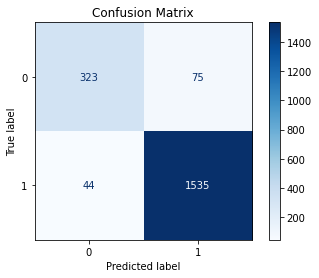

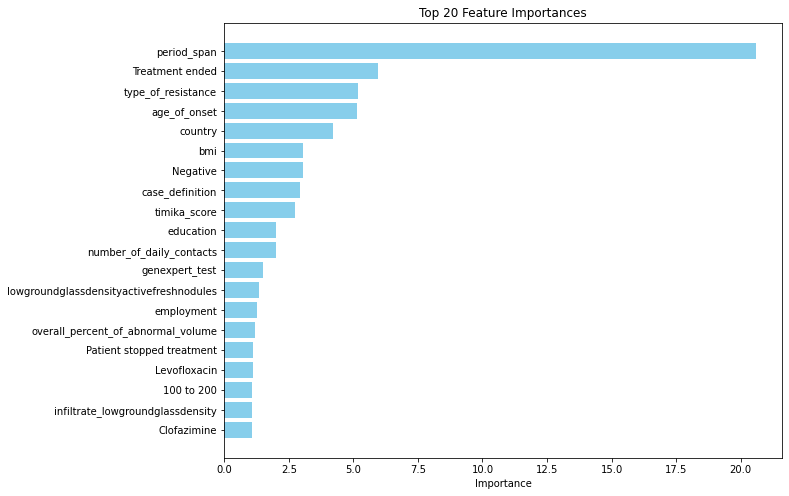

Testing parameters: {'l2_leaf_reg': 10.0, 'learning_rate': 0.01}
0:	learn: 0.6833765	total: 27.2ms	remaining: 40.8s
100:	learn: 0.3263826	total: 2.42s	remaining: 33.5s
200:	learn: 0.2631304	total: 4.79s	remaining: 30.9s
300:	learn: 0.2324772	total: 7.13s	remaining: 28.4s
400:	learn: 0.2116516	total: 9.44s	remaining: 25.9s
500:	learn: 0.1959900	total: 11.7s	remaining: 23.4s
600:	learn: 0.1828128	total: 14s	remaining: 21s
700:	learn: 0.1715832	total: 16.3s	remaining: 18.6s
800:	learn: 0.1608040	total: 18.6s	remaining: 16.2s
900:	learn: 0.1521183	total: 20.8s	remaining: 13.8s
1000:	learn: 0.1442648	total: 23s	remaining: 11.5s
1100:	learn: 0.1368326	total: 25.2s	remaining: 9.14s
1200:	learn: 0.1313201	total: 27.4s	remaining: 6.82s
1300:	learn: 0.1251017	total: 29.5s	remaining: 4.52s
1400:	learn: 0.1191793	total: 31.7s	remaining: 2.24s
1499:	learn: 0.1132476	total: 34s	remaining: 0us
Testing Accuracy: 0.9292
Sensitivity (Recall): 0.9512
Specificity: 0.8417


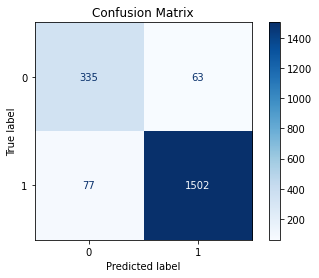

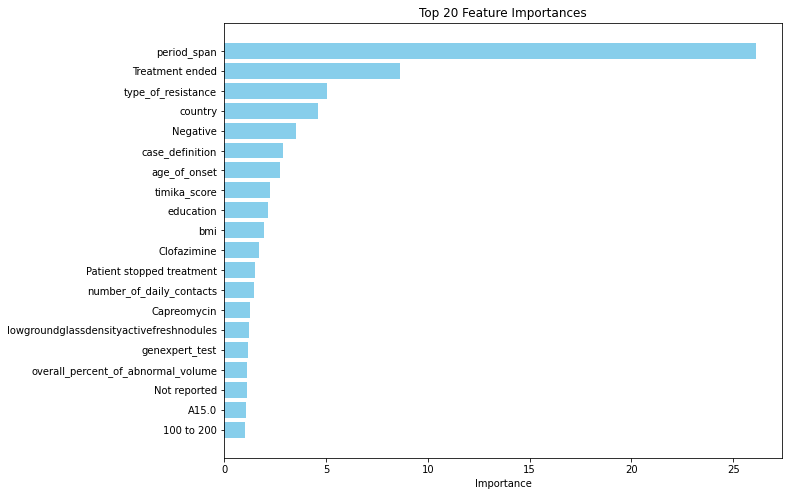

Testing parameters: {'l2_leaf_reg': 10.0, 'learning_rate': 0.05}
0:	learn: 0.6460184	total: 23.8ms	remaining: 35.7s
100:	learn: 0.1956727	total: 2.34s	remaining: 32.4s
200:	learn: 0.1463270	total: 4.57s	remaining: 29.5s
300:	learn: 0.1182205	total: 6.69s	remaining: 26.7s
400:	learn: 0.0951728	total: 8.87s	remaining: 24.3s
500:	learn: 0.0784494	total: 11.1s	remaining: 22s
600:	learn: 0.0692367	total: 13.1s	remaining: 19.7s
700:	learn: 0.0580785	total: 15.4s	remaining: 17.5s
800:	learn: 0.0495497	total: 17.6s	remaining: 15.4s
900:	learn: 0.0435401	total: 19.9s	remaining: 13.2s
1000:	learn: 0.0376296	total: 22.2s	remaining: 11.1s
1100:	learn: 0.0331004	total: 24.5s	remaining: 8.88s
1200:	learn: 0.0302215	total: 26.7s	remaining: 6.65s
1300:	learn: 0.0273440	total: 29s	remaining: 4.43s
1400:	learn: 0.0255387	total: 31.1s	remaining: 2.19s
1499:	learn: 0.0236552	total: 33.1s	remaining: 0us
Testing Accuracy: 0.9368
Sensitivity (Recall): 0.9690
Specificity: 0.8090


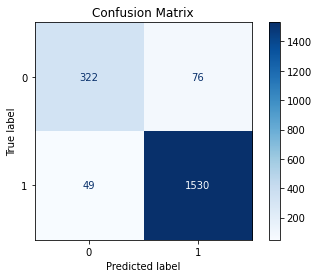

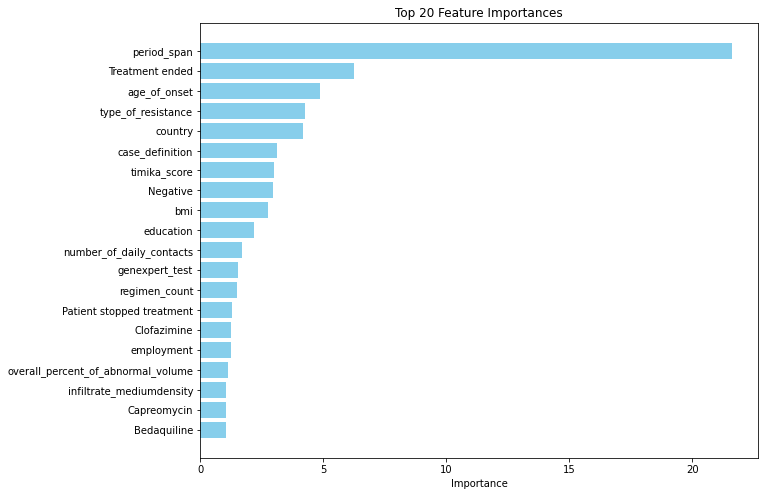

Testing parameters: {'l2_leaf_reg': 10.0, 'learning_rate': 0.1}
0:	learn: 0.6031916	total: 25.8ms	remaining: 38.7s
100:	learn: 0.1408127	total: 2.37s	remaining: 32.8s
200:	learn: 0.0917587	total: 4.58s	remaining: 29.6s
300:	learn: 0.0655590	total: 6.79s	remaining: 27s
400:	learn: 0.0464413	total: 8.99s	remaining: 24.6s
500:	learn: 0.0358107	total: 11.2s	remaining: 22.3s
600:	learn: 0.0305766	total: 13.2s	remaining: 19.8s
700:	learn: 0.0252222	total: 15.3s	remaining: 17.5s
800:	learn: 0.0218005	total: 17.4s	remaining: 15.2s
900:	learn: 0.0201147	total: 19.2s	remaining: 12.8s
1000:	learn: 0.0188812	total: 21s	remaining: 10.5s
1100:	learn: 0.0164151	total: 23s	remaining: 8.34s
1200:	learn: 0.0145052	total: 25s	remaining: 6.23s
1300:	learn: 0.0135756	total: 26.8s	remaining: 4.11s
1400:	learn: 0.0133098	total: 28.5s	remaining: 2.01s
1499:	learn: 0.0132083	total: 30.1s	remaining: 0us
Testing Accuracy: 0.9353
Sensitivity (Recall): 0.9696
Specificity: 0.7990


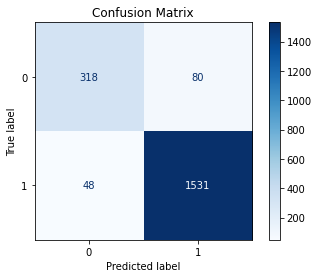

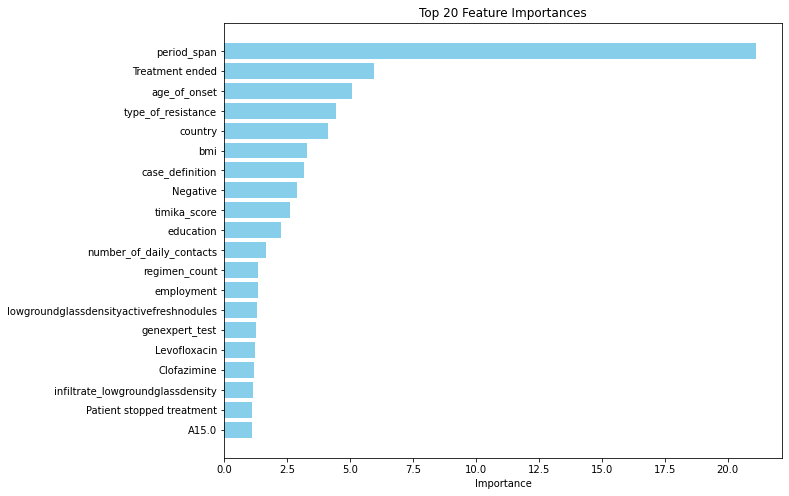

Testing parameters: {'l2_leaf_reg': 10.0, 'learning_rate': 0.2}
0:	learn: 0.5300038	total: 24.3ms	remaining: 36.4s
100:	learn: 0.0882425	total: 2.27s	remaining: 31.4s
200:	learn: 0.0454955	total: 4.39s	remaining: 28.4s
300:	learn: 0.0322713	total: 6.36s	remaining: 25.3s
400:	learn: 0.0222363	total: 8.41s	remaining: 23.1s
500:	learn: 0.0184438	total: 10.3s	remaining: 20.5s
600:	learn: 0.0165266	total: 12.1s	remaining: 18s
700:	learn: 0.0149807	total: 13.8s	remaining: 15.7s
800:	learn: 0.0138323	total: 15.5s	remaining: 13.6s
900:	learn: 0.0128062	total: 17.2s	remaining: 11.5s
1000:	learn: 0.0122662	total: 18.9s	remaining: 9.42s
1100:	learn: 0.0117525	total: 20.5s	remaining: 7.44s
1200:	learn: 0.0112888	total: 22.2s	remaining: 5.53s
1300:	learn: 0.0110950	total: 23.8s	remaining: 3.64s
1400:	learn: 0.0108543	total: 25.4s	remaining: 1.79s
1499:	learn: 0.0106845	total: 27s	remaining: 0us
Testing Accuracy: 0.9383
Sensitivity (Recall): 0.9702
Specificity: 0.8116


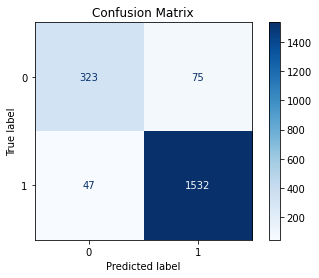

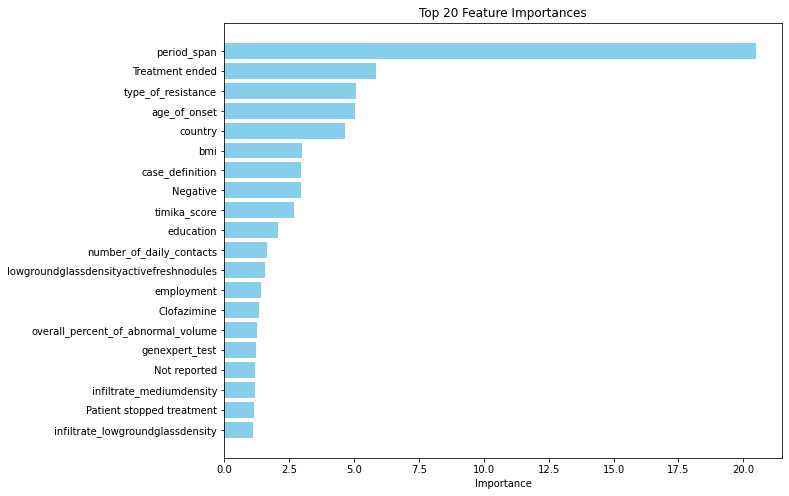

Testing parameters: {'l2_leaf_reg': 20.0, 'learning_rate': 0.01}
0:	learn: 0.6830038	total: 26.6ms	remaining: 39.8s
100:	learn: 0.3350916	total: 2.43s	remaining: 33.7s
200:	learn: 0.2720349	total: 4.8s	remaining: 31s
300:	learn: 0.2419711	total: 7.11s	remaining: 28.3s
400:	learn: 0.2218804	total: 9.4s	remaining: 25.8s
500:	learn: 0.2065960	total: 11.7s	remaining: 23.4s
600:	learn: 0.1938698	total: 14s	remaining: 20.9s
700:	learn: 0.1836186	total: 16.2s	remaining: 18.4s
800:	learn: 0.1748695	total: 18.3s	remaining: 16s
900:	learn: 0.1660886	total: 20.5s	remaining: 13.6s
1000:	learn: 0.1587826	total: 22.7s	remaining: 11.3s
1100:	learn: 0.1511693	total: 24.8s	remaining: 8.99s
1200:	learn: 0.1464685	total: 26.8s	remaining: 6.67s
1300:	learn: 0.1419490	total: 28.8s	remaining: 4.41s
1400:	learn: 0.1382906	total: 30.8s	remaining: 2.17s
1499:	learn: 0.1346053	total: 32.7s	remaining: 0us
Testing Accuracy: 0.9272
Sensitivity (Recall): 0.9481
Specificity: 0.8442


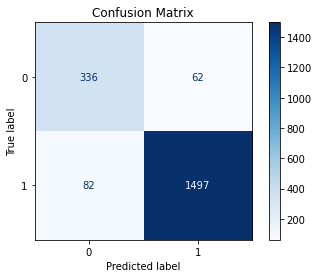

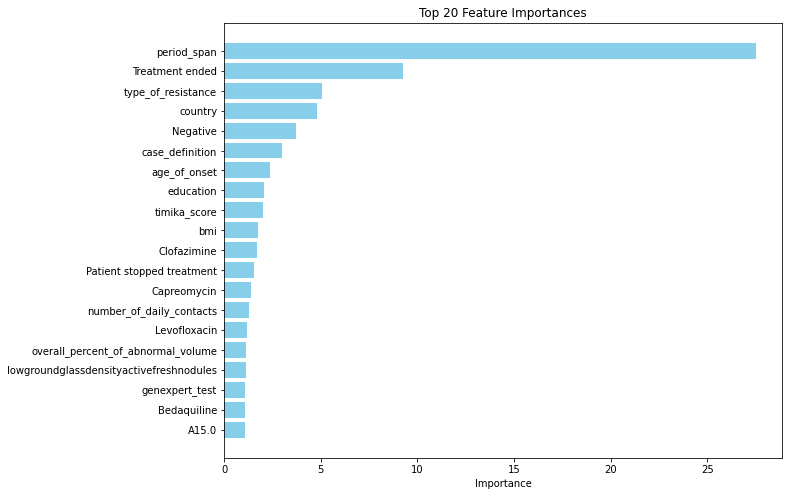

Testing parameters: {'l2_leaf_reg': 20.0, 'learning_rate': 0.05}
0:	learn: 0.6442930	total: 26.7ms	remaining: 40.1s
100:	learn: 0.2061370	total: 2.32s	remaining: 32.2s
200:	learn: 0.1591545	total: 4.53s	remaining: 29.3s
300:	learn: 0.1318414	total: 6.64s	remaining: 26.5s
400:	learn: 0.1113943	total: 8.76s	remaining: 24s
500:	learn: 0.0972072	total: 10.8s	remaining: 21.6s
600:	learn: 0.0858444	total: 13s	remaining: 19.4s
700:	learn: 0.0761202	total: 15.1s	remaining: 17.2s
800:	learn: 0.0705831	total: 17.1s	remaining: 14.9s
900:	learn: 0.0623885	total: 19.3s	remaining: 12.8s
1000:	learn: 0.0556138	total: 21.5s	remaining: 10.7s
1100:	learn: 0.0500899	total: 23.6s	remaining: 8.55s
1200:	learn: 0.0459135	total: 25.7s	remaining: 6.41s
1300:	learn: 0.0426320	total: 27.7s	remaining: 4.24s
1400:	learn: 0.0389978	total: 29.8s	remaining: 2.1s
1499:	learn: 0.0365020	total: 31.7s	remaining: 0us
Testing Accuracy: 0.9353
Sensitivity (Recall): 0.9652
Specificity: 0.8166


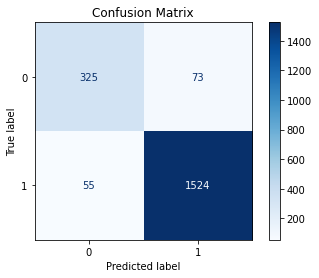

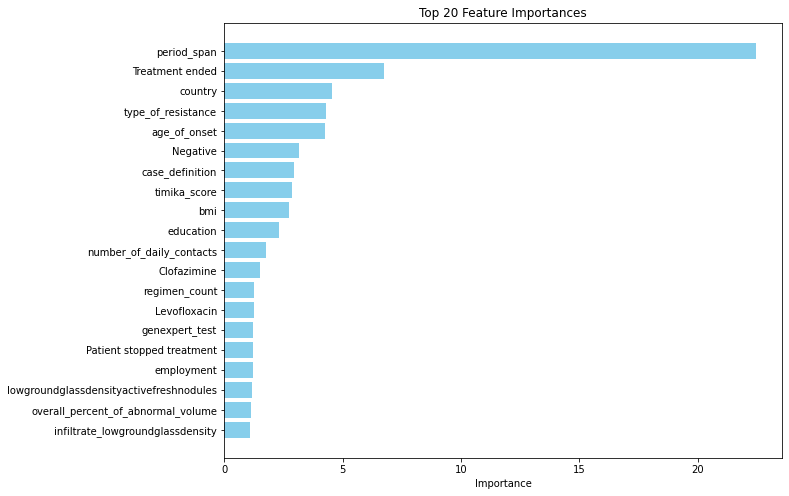

Testing parameters: {'l2_leaf_reg': 20.0, 'learning_rate': 0.1}
0:	learn: 0.6000767	total: 26.2ms	remaining: 39.3s
100:	learn: 0.1545814	total: 2.32s	remaining: 32.2s
200:	learn: 0.1096332	total: 4.49s	remaining: 29s
300:	learn: 0.0865865	total: 6.6s	remaining: 26.3s
400:	learn: 0.0672502	total: 8.72s	remaining: 23.9s
500:	learn: 0.0522821	total: 10.9s	remaining: 21.7s
600:	learn: 0.0433334	total: 13s	remaining: 19.5s
700:	learn: 0.0379127	total: 15s	remaining: 17.1s
800:	learn: 0.0349522	total: 16.9s	remaining: 14.7s
900:	learn: 0.0324855	total: 18.7s	remaining: 12.5s
1000:	learn: 0.0305012	total: 20.6s	remaining: 10.3s
1100:	learn: 0.0283340	total: 22.5s	remaining: 8.14s
1200:	learn: 0.0275120	total: 24.2s	remaining: 6.02s
1300:	learn: 0.0261844	total: 26s	remaining: 3.97s
1400:	learn: 0.0246591	total: 27.8s	remaining: 1.96s
1499:	learn: 0.0230633	total: 29.7s	remaining: 0us
Testing Accuracy: 0.9383
Sensitivity (Recall): 0.9683
Specificity: 0.8191


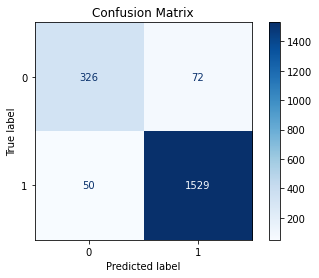

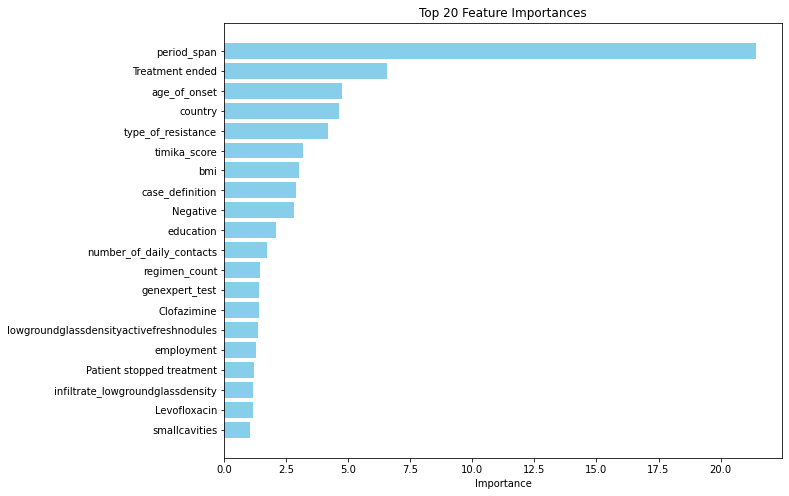

Testing parameters: {'l2_leaf_reg': 20.0, 'learning_rate': 0.2}
0:	learn: 0.5249958	total: 27ms	remaining: 40.5s
100:	learn: 0.1054201	total: 2.22s	remaining: 30.7s
200:	learn: 0.0614007	total: 4.36s	remaining: 28.2s
300:	learn: 0.0479977	total: 6.29s	remaining: 25.1s
400:	learn: 0.0354687	total: 8.31s	remaining: 22.8s
500:	learn: 0.0260439	total: 10.4s	remaining: 20.8s
600:	learn: 0.0209782	total: 12.5s	remaining: 18.7s
700:	learn: 0.0185988	total: 14.4s	remaining: 16.4s
800:	learn: 0.0173094	total: 16.1s	remaining: 14s
900:	learn: 0.0161488	total: 17.8s	remaining: 11.8s
1000:	learn: 0.0144090	total: 19.7s	remaining: 9.81s
1100:	learn: 0.0132204	total: 21.5s	remaining: 7.78s
1200:	learn: 0.0127613	total: 23.1s	remaining: 5.76s
1300:	learn: 0.0117960	total: 24.9s	remaining: 3.81s
1400:	learn: 0.0110597	total: 26.7s	remaining: 1.89s
1499:	learn: 0.0109382	total: 28.3s	remaining: 0us
Testing Accuracy: 0.9378
Sensitivity (Recall): 0.9702
Specificity: 0.8090


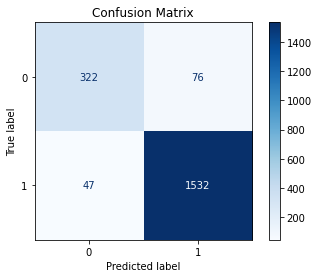

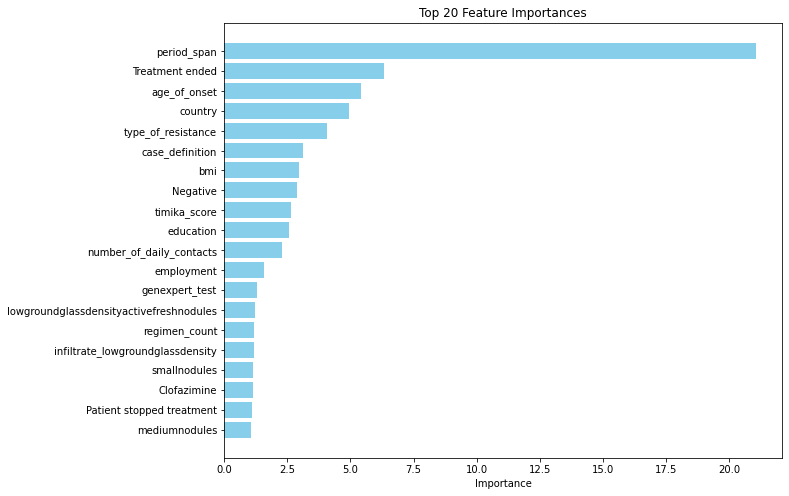

Best Hyperparameters:
{'l2_leaf_reg': 5.0, 'learning_rate': 0.2}
Best Metrics:
{'Testing Accuracy': 0.939807789580172, 'Sensitivity (Recall)': 0.9721342621912603, 'Specificity': 0.8115577889447236}


In [23]:
from sklearn.model_selection import ParameterGrid

# Define a range of hyperparameters for grid search
param_grid = {
    'l2_leaf_reg': [1.0, 5.0, 10.0, 20.0],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}

# Initialize to track the best results
best_params = None
best_metrics = {'Testing Accuracy': 0, 'Sensitivity (Recall)': 0, 'Specificity': 0}
best_model = None

# Perform grid search
for params in ParameterGrid(param_grid):
    print(f"Testing parameters: {params}")
    model, metrics = evaluate_catboost_classifier_split_weighted(
        X_train_resampled, X_test, y_train_resampled['outcome'], y_test,
        l2_leaf_reg=params['l2_leaf_reg'],
        learning_rate=params['learning_rate'],
        iterations=1500,
        depth=8,
        random_state=42
    )
    
    # Check if this combination is better
    if metrics['Testing Accuracy'] > best_metrics['Testing Accuracy']:
        best_params = params
        best_metrics = metrics
        best_model = model

# Output the best results
print("Best Hyperparameters:")
print(best_params)
print("Best Metrics:")
print(best_metrics)


In [203]:
np.array(y_train_resampled)


array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [201]:
np.array(y_train['outcome'])


array([1, 1, 1, ..., 1, 0, 1])

#### grid search on regularisation values

Best Parameters: {'reg_alpha': 1, 'reg_lambda': 0}
Best Score: 0.9342
Testing Accuracy: 0.9342
Sensitivity (Recall): 0.9645
Specificity: 0.8141


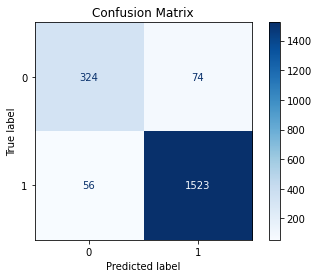

In [134]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score
import numpy as np

def grid_search_xgboost_no_cv(X_train, y_train, X_test, y_test, param_grid, scoring='accuracy', random_state=42):
    """
    Performs grid search to optimize reg_alpha and reg_lambda for XGBoost classifier without cross-validation.

    Parameters:
    - X_train (pd.DataFrame or np.array): Training feature set.
    - y_train (pd.Series or np.array): Training target variable.
    - X_test (pd.DataFrame or np.array): Testing feature set.
    - y_test (pd.Series or np.array): Testing target variable.
    - param_grid (dict): Dictionary with parameter names (`reg_alpha`, `reg_lambda`) as keys and lists of parameter settings to try as values.
    - scoring (str): Scoring metric for evaluation ('accuracy', 'sensitivity', or 'specificity').
    - random_state (int): Random seed for reproducibility.

    Returns:
    - best_params (dict): Best parameter combination found.
    - best_score (float): Best score achieved with the best parameter combination.
    - best_model (XGBClassifier): Best estimator found by the grid search.
    """
    best_score = -np.inf
    best_params = None
    best_model = None

    # Iterate over all combinations of reg_alpha and reg_lambda
    for reg_alpha in param_grid['reg_alpha']:
        for reg_lambda in param_grid['reg_lambda']:
            # Initialize the XGBoost classifier with current parameters
            model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',
                                  reg_alpha=reg_alpha, reg_lambda=reg_lambda,
                                  random_state=random_state)
            # Train the model
            model.fit(X_train, y_train)

            # Predict on the test data
            y_test_pred = model.predict(X_test)

            # Calculate the desired scoring metric
            if scoring == 'accuracy':
                score = accuracy_score(y_test, y_test_pred)
            elif scoring == 'sensitivity':
                score = recall_score(y_test, y_test_pred, pos_label=1)
            elif scoring == 'specificity':
                score = recall_score(y_test, y_test_pred, pos_label=0)
            else:
                raise ValueError("Unsupported scoring metric. Choose from 'accuracy', 'sensitivity', or 'specificity'.")

            # Update best parameters if current score is better
            if score > best_score:
                best_score = score
                best_params = {'reg_alpha': reg_alpha, 'reg_lambda': reg_lambda}
                best_model = model

    return best_params, best_score, best_model


param_grid = {
    'reg_alpha': [0, 0.1, 1, 10, 100],
    'reg_lambda': [0, 0.1, 1, 10, 100]
}

# Assuming X_train_resampled and y_train_resampled are your training data
# Assuming X_train_resampled, y_train_resampled, X_test, and y_test are your datasets
best_params, best_score, best_model = grid_search_xgboost_no_cv(
    X_train_resampled, y_train_resampled, X_test, y_test, param_grid, scoring='accuracy'
)

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score:.4f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on the test data
y_test_pred = best_model.predict(X_test)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)

# Calculate sensitivity (recall) and specificity
sensitivity = recall_score(y_test, y_test_pred, pos_label=1)
specificity = recall_score(y_test, y_test_pred, pos_label=0)

# Compile metrics into a dictionary
metrics = {
    'Testing Accuracy': test_accuracy,
    'Sensitivity (Recall)': sensitivity,
    'Specificity': specificity
}

# Print metrics
for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")

# Generate and plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [ ]:
e

### feature importance

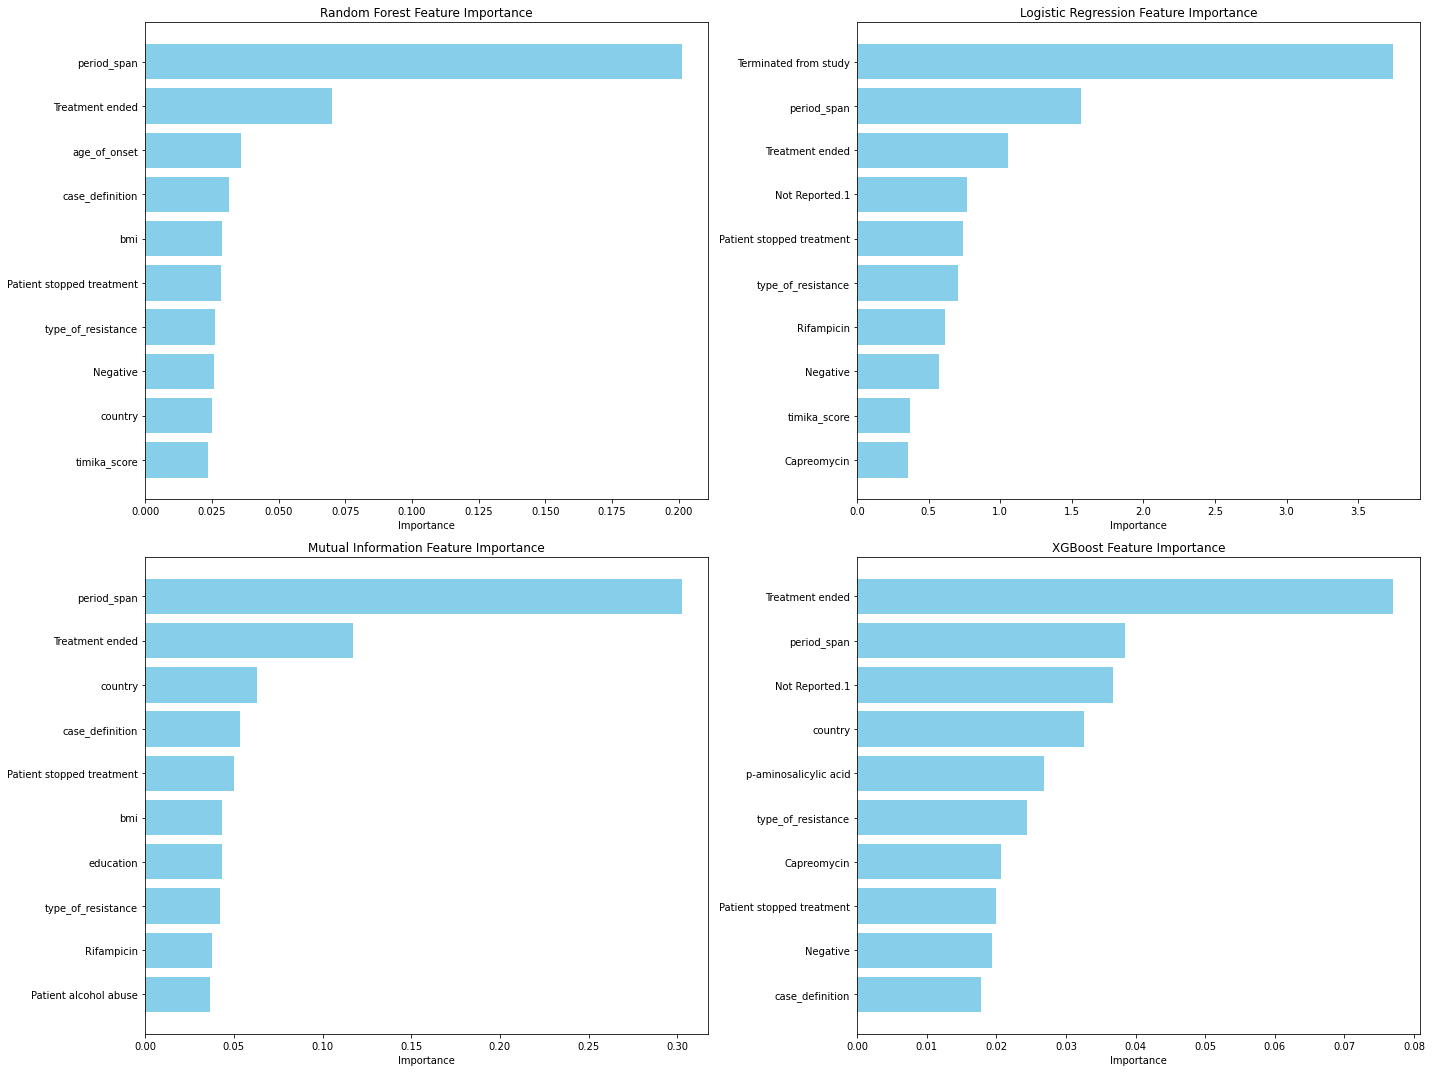

In [187]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler

# Impute missing values using the most frequent strategy
imputer = SimpleImputer(strategy='most_frequent')
clinical_lung_features_imputed = imputer.fit_transform(clinical_lung_features)

# Convert back to a DataFrame
clinical_lung_features_imputed_df = pd.DataFrame(
    clinical_lung_features_imputed, columns=clinical_lung_features.columns
)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    clinical_lung_features_imputed_df,
    clinical_lung_target,
    test_size=0.2,
    random_state=42,
    stratify=clinical_lung_target,
    shuffle=True
)

# Resample the training data
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Feature Importance Methods
feature_methods = {}

# 1. Random Forest Feature Importance
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train_resampled)
rf_importance = rf_model.feature_importances_
feature_methods['Random Forest'] = rf_importance

# 2. Logistic Regression Coefficients
lr_model = LogisticRegression(random_state=42, max_iter=5000)
lr_model.fit(X_train_scaled, y_train_resampled)
lr_importance = np.abs(lr_model.coef_[0])
feature_methods['Logistic Regression'] = lr_importance

# 3. Mutual Information
mi_importance = mutual_info_classif(X_train_scaled, y_train_resampled, random_state=42)
feature_methods['Mutual Information'] = mi_importance

# 4. XGBoost Feature Importance
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train_resampled)
xgb_importance = xgb_model.feature_importances_
feature_methods['XGBoost'] = xgb_importance

# Visualization
plt.figure(figsize=(20, 15))

for i, (method, importance) in enumerate(feature_methods.items(), start=1):
    plt.subplot(2, 2, i)
    sorted_indices = np.argsort(importance)[::-1]
    top_features = clinical_lung_features.columns[sorted_indices][:10]
    top_importance = importance[sorted_indices][:10]
    plt.barh(top_features, top_importance, color='skyblue')
    plt.title(f"{method} Feature Importance")
    plt.xlabel("Importance")
    plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


In [188]:

import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Impute missing values using the most frequent strategy
imputer = SimpleImputer(strategy='most_frequent')
clinical_lung_features_imputed = imputer.fit_transform(clinical_lung_features)

# Convert back to a DataFrame
clinical_lung_features_imputed_df = pd.DataFrame(
    clinical_lung_features_imputed, columns=clinical_lung_features.columns
)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    clinical_lung_features_imputed_df,
    clinical_lung_target,
    test_size=0.2,
    random_state=42,
    stratify=clinical_lung_target,
    shuffle=True
)

# Resample the training data
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Feature Importance Methods
feature_methods = {}

# 1. Random Forest Feature Importance
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train_resampled)
rf_importance = rf_model.feature_importances_
feature_methods['Random Forest'] = rf_importance

# 2. Logistic Regression Coefficients
lr_model = LogisticRegression(random_state=42, max_iter=5000)
lr_model.fit(X_train_scaled, y_train_resampled)
lr_importance = np.abs(lr_model.coef_[0])
feature_methods['Logistic Regression'] = lr_importance

# 3. Mutual Information
mi_importance = mutual_info_classif(X_train_scaled, y_train_resampled, random_state=42)
feature_methods['Mutual Information'] = mi_importance

# 4. XGBoost Feature Importance
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train_resampled)
xgb_importance = xgb_model.feature_importances_
feature_methods['XGBoost'] = xgb_importance

# Identify features accounting for 95% cumulative importance
feature_95_percent = {}

for method, importance in feature_methods.items():
    sorted_indices = np.argsort(importance)[::-1]
    sorted_importance = importance[sorted_indices]
    sorted_features = clinical_lung_features.columns[sorted_indices]
    
    # Calculate cumulative importance
    cumulative_importance = np.cumsum(sorted_importance)
    threshold_index = np.argmax(cumulative_importance >= 0.95) + 1
    top_95_features = sorted_features[:threshold_index]
    
    feature_95_percent[method] = top_95_features

# Print out the top features that account for 95% cumulative importance for each method
for method, top_features in feature_95_percent.items():
    print(f"\n{method} - Features accounting for 95% cumulative importance:")
    print(top_features)




Random Forest - Features accounting for 95% cumulative importance:
Index(['period_span', 'Treatment ended', 'age_of_onset', 'case_definition',
       'bmi', 'Patient stopped treatment', 'type_of_resistance', 'Negative',
       'country', 'timika_score', 'education', 'number_of_daily_contacts',
       'Not reported', 'employment', 'Not Reported', 'Patient alcohol abuse',
       'regimen_count', 'Rifampicin', 'Continuation of treatment',
       'Not Reported.3', 'smallnodules',
       'mediumdensitystabalizedfibroticnodules',
       'lowgroundglassdensityactivefreshnodules',
       'infiltrate_lowgroundglassdensity', 'isanynoncalcifiednoduleexist',
       'mediumnodules', 'bactec_rifampicin',
       'overall_percent_of_abnormal_volume', 'genexpert_test',
       'infiltrate_mediumdensity', 'bactec_ethambutol',
       'aremultiplenoduleexists', 'smallcavities', 'Anemia', 'Isoniazid',
       'Levofloxacin', 'gender',
       'Treatment ineffective due to additional resistance', 'Capreomycin

### removing period span columns again

Testing Accuracy: 0.8644
Sensitivity (Recall): 0.8822
Specificity: 0.7940


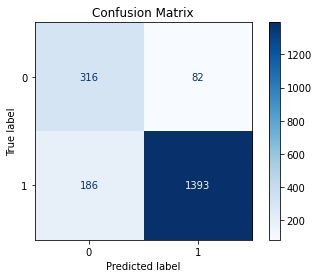

<Figure size 1080x1800 with 0 Axes>

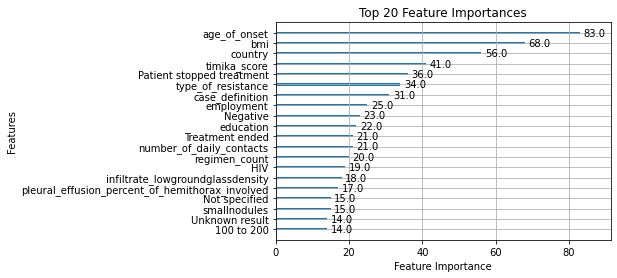

(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='mlogloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=None, num_parallel_tree=None, random_state=42, ...),
 {'Testing Accuracy': 0.8644410723318159,
  'Sensitivity (Recall)': 0.8822039265357822,
  'Specificity': 0.7939698492462312})

In [186]:
X_train_resampled.drop(columns=['period_span'], inplace=True)
X_test.drop(columns=['period_span'], inplace=True)


evaluate_xgboost_classifier_split(X_train_resampled, X_test, y_train_resampled, y_test, reg_alpha=38, reg_lambda=69,  random_state=42)

dropping period span drops accuracy by 5%, sensitivity by 2%, specificity by 8%

### adjust classification threshold

In [102]:
from sklearn.metrics import recall_score, precision_recall_curve

# Obtain predicted probabilities
y_test_probs = model.predict_proba(X_test)[:, 1]

# Determine optimal threshold
precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
optimal_idx = np.argmax(f1_scores)
# optimal_threshold = thresholds[optimal_idx]
optimal_threshold = 0.7


# Apply the optimal threshold
y_test_pred_optimal = (y_test_probs >= optimal_threshold).astype(int)

# Evaluate performance
sensitivity_optimal = recall_score(y_test, y_test_pred_optimal, pos_label=1)
specificity_optimal = recall_score(y_test, y_test_pred_optimal, pos_label=0)

print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Sensitivity (Recall) at Optimal Threshold: {sensitivity_optimal:.4f}")
print(f"Specificity at Optimal Threshold: {specificity_optimal:.4f}")


Optimal Threshold: 0.70
Sensitivity (Recall) at Optimal Threshold: 0.5370
Specificity at Optimal Threshold: 0.4472
